In [1]:
%matplotlib inline
from IPython.display import display
from matplotlib import pyplot as plt

import os
import sys
import torch
import random
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import seaborn as sns
from datetime import datetime

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

sys.path.append('../')
from MyPyUtil.logconf import logging
from MyPyUtil.util import show_more_rows, seed_everything

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

seed_everything()

pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False
pd.options.display.float_format = "{:.3f}".format

# max output width in numpy
np.set_printoptions(
    threshold=sys.maxsize,  # 20,
    edgeitems=10,
    linewidth=140,
    formatter=dict(float=lambda x: "%.3g" % x),
)  # float arrays %.3g

data_dir = f"{os.getcwd()}/../data/"
resources_dir = f"{os.getcwd()}/../resources/"

if os.path.exists(resources_dir) == False:
    os.makedirs(resources_dir, exist_ok=True)

if os.path.exists(data_dir) == False:
    os.makedirs(data_dir, exist_ok=True)

**download stocks list from ftp://ftp.nasdaqtrader.com/symboldirectory**  
[**reference: nasdaqtrader**](https://www.nasdaqtrader.com/trader.aspx?id=symboldirdefs)

- **Market Category:** The category assigned to the issue by NASDAQ based on Listing Requirements. Values:  
   Q = NASDAQ Global Select MarketSM  
   G = NASDAQ Global MarketSM  
   S = NASDAQ Capital Market

- **Test Issue:** Indicates whether or not the security is a test security. Values:  
   Y = yes, it is a test issue.  
   N = no, it is not a test issue.

- **Financial Status:** Indicates when an issuer has failed to submit its regulatory filings on a timely basis, has failed to meet NASDAQ's continuing listing standards, and/or has filed for bankruptcy. Values include:
  D = Deficient: Issuer Failed to Meet NASDAQ Continued Listing Requirements  
  E = Delinquent: Issuer Missed Regulatory Filing Deadline  
  Q = Bankrupt: Issuer Has Filed for Bankruptcy  
  N = Normal (Default): Issuer Is NOT Deficient, Delinquent, or Bankrupt.  
  G = Deficient and Bankrupt  
  H = Deficient and Delinquent  
  J = Delinquent and Bankrupt  
  K = Deficient, Delinquent, and Bankrupt


In [3]:
from ftplib import FTP

# Connect to the FTP server
ftp = FTP("ftp.nasdaqtrader.com")
ftp.login(user="anonymous", passwd="aaa@aaa.com")

# Change to the desired directory
ftp.cwd("symboldirectory")

# Download a file (e.g., 'example.txt') to the local machine
with open("nasdaqlisted.txt", "wb") as local_file:
    ftp.retrbinary("RETR nasdaqlisted.txt", local_file.write)

# Close the FTP connection
ftp.quit()

'221 Goodbye.'

In [4]:
stocks_list = pd.read_csv("nasdaqlisted.txt", delimiter="|")
stocks_list.drop(index=stocks_list.index[-1], axis=0, inplace=True)
stocks_list = stocks_list[
    (stocks_list["Test Issue"] == "N")
    & (stocks_list["ETF"] == "N")
    & (stocks_list["Financial Status"] == "N")
]
display(stocks_list)
stocks_list.groupby("Market Category").count()["Symbol"]

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares
0,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.000,N,N
1,AACI,Armada Acquisition Corp. I - Common Stock,G,N,N,100.000,N,N
2,AACIU,Armada Acquisition Corp. I - Unit,G,N,N,100.000,N,N
3,AACIW,Armada Acquisition Corp. I - Warrant,G,N,N,100.000,N,N
4,AADI,"Aadi Bioscience, Inc. - Common Stock",S,N,N,100.000,N,N
...,...,...,...,...,...,...,...,...
4911,ZURA,Zura Bio Limited - Class A Ordinary shares,S,N,N,100.000,N,N
4912,ZURAW,Zura Bio Limited - Warrant,S,N,N,100.000,N,N
4913,ZVRA,"Zevra Therapeutics, Inc. - Common Stock",Q,N,N,100.000,N,N
4919,ZYME,Zymeworks Inc. - Common Stock,Q,N,N,100.000,N,N


Market Category
G     819
Q    1544
S    1277
Name: Symbol, dtype: int64

In [5]:
display(stocks_list.isnull().sum())
NaN_symbol = stocks_list[stocks_list["Symbol"].isnull()]
display(NaN_symbol)

Symbol              1
Security Name       0
Market Category     0
Test Issue          0
Financial Status    0
Round Lot Size      0
ETF                 0
NextShares          0
dtype: int64

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares
2997,NaN,Nano Labs Ltd - Class A Ordinary Shares,G,N,N,100.000,N,N


In [6]:
stocks_list.drop(NaN_symbol.index, inplace=True)
display(stocks_list)
display(stocks_list.groupby("Market Category").count()["Symbol"])

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares
0,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.000,N,N
1,AACI,Armada Acquisition Corp. I - Common Stock,G,N,N,100.000,N,N
2,AACIU,Armada Acquisition Corp. I - Unit,G,N,N,100.000,N,N
3,AACIW,Armada Acquisition Corp. I - Warrant,G,N,N,100.000,N,N
4,AADI,"Aadi Bioscience, Inc. - Common Stock",S,N,N,100.000,N,N
...,...,...,...,...,...,...,...,...
4911,ZURA,Zura Bio Limited - Class A Ordinary shares,S,N,N,100.000,N,N
4912,ZURAW,Zura Bio Limited - Warrant,S,N,N,100.000,N,N
4913,ZVRA,"Zevra Therapeutics, Inc. - Common Stock",Q,N,N,100.000,N,N
4919,ZYME,Zymeworks Inc. - Common Stock,Q,N,N,100.000,N,N


Market Category
G     819
Q    1544
S    1277
Name: Symbol, dtype: int64

In [7]:
sectors_file = f"{resources_dir}/sectors.csv"
if os.path.exists(sectors_file):
    sectors = pd.read_csv(f"{resources_dir}/sectors.csv").fillna("")
    sectors.drop(columns=sectors.columns[0], axis=1, inplace=True)
    display(sectors.groupby("Sector").count())
else:
    sectors = pd.DataFrame(columns=["Symbol", "Sector"])
    display(sectors)

,Symbol
Sector,
,197
Basic Materials,88
Communication Services,184
Consumer Cyclical,324
Consumer Defensive,153
Energy,75
Financial Services,917
Healthcare,987
Industrials,354


In [8]:
import yfinance as yfin

tmp_list = stocks_list.merge(sectors, how="left", on="Symbol")
stocks_without_sector = tmp_list[tmp_list.Sector.isna()]
symbols_without_sector = stocks_without_sector.Symbol.values

retrived_tickers_info = [yfin.Ticker(symbol) for symbol in symbols_without_sector]
retrived_sectors = pd.DataFrame(
    data={
        "Symbol": symbols_without_sector,
        "Sector": [
            t.info["sector"] if "sector" in t.info.keys() else ""
            for t in retrived_tickers_info
        ],
    }
)

display(retrived_sectors)

,Symbol,Sector


In [9]:
new_sectors = retrived_sectors.merge(sectors, on=["Symbol", "Sector"], how="outer")
new_sectors.to_csv(sectors_file)
new_sectors

,Symbol,Sector
0,A,Healthcare
1,AACG,Consumer Defensive
2,AACI,Financial Services
3,AACIU,Financial Services
4,AACIW,Financial Services
...,...,...
4018,ZURA,Healthcare
4019,ZURAW,
4020,ZVRA,Healthcare
4021,ZYME,Healthcare


In [10]:
stocks_list = stocks_list.merge(new_sectors, how="left", on="Symbol")

display(stocks_list)
stocks_list.groupby("Sector").Symbol.count()

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares,Sector
0,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.000,N,N,Consumer Defensive
1,AACI,Armada Acquisition Corp. I - Common Stock,G,N,N,100.000,N,N,Financial Services
2,AACIU,Armada Acquisition Corp. I - Unit,G,N,N,100.000,N,N,Financial Services
3,AACIW,Armada Acquisition Corp. I - Warrant,G,N,N,100.000,N,N,Financial Services
4,AADI,"Aadi Bioscience, Inc. - Common Stock",S,N,N,100.000,N,N,Healthcare
...,...,...,...,...,...,...,...,...,...
3635,ZURA,Zura Bio Limited - Class A Ordinary shares,S,N,N,100.000,N,N,Healthcare
3636,ZURAW,Zura Bio Limited - Warrant,S,N,N,100.000,N,N,
3637,ZVRA,"Zevra Therapeutics, Inc. - Common Stock",Q,N,N,100.000,N,N,Healthcare
3638,ZYME,Zymeworks Inc. - Common Stock,Q,N,N,100.000,N,N,Healthcare


Sector
                          193
Basic Materials            66
Communication Services    178
Consumer Cyclical         284
Consumer Defensive        124
Energy                     55
Financial Services        850
Healthcare                932
Industrials               295
Real Estate                86
Technology                541
Utilities                  36
Name: Symbol, dtype: int64

In [11]:
stocks_with_empty_sector = stocks_list[stocks_list.Sector == ""]
stocks_list.drop(stocks_with_empty_sector.index, inplace=True)
display(stocks_list)

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares,Sector
0,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.000,N,N,Consumer Defensive
1,AACI,Armada Acquisition Corp. I - Common Stock,G,N,N,100.000,N,N,Financial Services
2,AACIU,Armada Acquisition Corp. I - Unit,G,N,N,100.000,N,N,Financial Services
3,AACIW,Armada Acquisition Corp. I - Warrant,G,N,N,100.000,N,N,Financial Services
4,AADI,"Aadi Bioscience, Inc. - Common Stock",S,N,N,100.000,N,N,Healthcare
...,...,...,...,...,...,...,...,...,...
3634,ZUMZ,Zumiez Inc. - Common Stock,Q,N,N,100.000,N,N,Consumer Cyclical
3635,ZURA,Zura Bio Limited - Class A Ordinary shares,S,N,N,100.000,N,N,Healthcare
3637,ZVRA,"Zevra Therapeutics, Inc. - Common Stock",Q,N,N,100.000,N,N,Healthcare
3638,ZYME,Zymeworks Inc. - Common Stock,Q,N,N,100.000,N,N,Healthcare


## Load Stock Data


In [12]:
new_sectors.set_index("Symbol", inplace=True)
new_sectors

,Sector
Symbol,
A,Healthcare
AACG,Consumer Defensive
AACI,Financial Services
AACIU,Financial Services
AACIW,Financial Services
...,...
ZURA,Healthcare
ZURAW,
ZVRA,Healthcare


In [13]:
from collections import namedtuple
from MyPyUtil.util import is_contained
from tqdm import tqdm

tick_data_info = namedtuple("tick_data_info", "idx symbol sector tick_data")


def load_stk_data(stk_symbols, start, end, empty_vol_threshold):

    ticks_data = []

    error_download = []
    error_sector_not_found = []
    error_numerical = []
    error_volumn = []
    error_empty = []
    for idx, symbol in enumerate(tqdm(stk_symbols)):
        if new_sectors.loc[symbol].Sector == "":
            log.warning(f"{symbol}: Its sector cannot be found")
            error_sector_not_found.append(symbol)
            continue

        stk_file = f"{data_dir}{symbol}_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.csv"
        bLoad = False
        if os.path.isfile(stk_file):
            try:
                _stk_data = pd.read_csv(stk_file).set_index("Date")
                bLoad = True
                log.info(f"read {stk_file} completely!")
            except:
                None
        if bLoad == False:
            # _stk_data = web.get_data_yahoo(stk_tickers, start, end)
            try:
                _stk_data = yfin.download([symbol], start, end).dropna()
                _stk_data.to_csv(stk_file)
                log.info(
                    f"download {symbol} from yfin and write to {stk_file} completely!"
                )
            except:
                error_download.append(symbol)
                continue
        statistics = _stk_data.describe()
        if is_contained(statistics, 0):
            if is_contained(
                statistics.loc[:, ["Open", "High", "Low", "Close", "Adj Close"]], 0
            ) or is_contained(statistics.loc["std"], 0):
                log.warning(f"{symbol}: contains numerical errors. Ignore it.")
                error_numerical.append(symbol)
                continue
            else:
                empty_vol_index = _stk_data[_stk_data["Volume"] == 0].index
                if len(empty_vol_index) > empty_vol_threshold:
                    log.warning(
                        f"The total volume with a value of zero ({len(empty_vol_index)}) is greater than the threshold({empty_vol_threshold}). Ignore it."
                    )
                    error_volumn.append(symbol)
                    continue
                log.info(
                    f"A total of {len(empty_vol_index)} volume values ​​are zero. Delete these data."
                )

                cleaned_data = _stk_data.drop(empty_vol_index)
                log.info(
                    f"The cleaned data size is {len(cleaned_data)}. The original data size is {len(_stk_data)}."
                )
                if len(cleaned_data) == 0:
                    error_empty.append(symbol)
                    log.warning(f"The cleaned data size is {len(cleaned_data)}.")
                    continue
                _stk_data = cleaned_data

        ticks_data.append(
            tick_data_info(idx, symbol, new_sectors.loc[symbol].Sector, _stk_data)
        )
        log.info(f"{symbol}, size:{len(_stk_data)}")
    return ticks_data, (
        error_download,
        error_sector_not_found,
        error_numerical,
        error_volumn,
        error_empty,
    )

In [14]:
log.setLevel(logging.ERROR)

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)

empty_vol_threshold = 10
stks_data, (
    error_download,
    error_sector_not_found,
    error_numerical,
    error_volumn,
    error_empty,
) = load_stk_data(
    stocks_list.Symbol.values,
    start,
    end,
    empty_vol_threshold,
)
display(len(stks_data))

log.setLevel(logging.INFO)

100%|██████████| 3447/3447 [00:16<00:00, 210.35it/s]


2259

In [15]:
stks_data[0].tick_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-16,69.750,72.750,64.200,67.500,67.500,1527
2018-02-20,65.700,66.000,63.750,66.000,66.000,353
2018-02-21,60.000,74.850,60.000,71.250,71.250,733
2018-02-22,67.650,71.250,66.750,68.745,68.745,213
2018-02-23,65.250,67.500,65.250,67.500,67.500,360
...,...,...,...,...,...,...
2023-12-22,1.980,2.060,1.900,1.970,1.970,725600
2023-12-26,2.030,2.095,1.990,2.010,2.010,477200
2023-12-27,2.010,2.100,2.010,2.080,2.080,608300


In [16]:
import joblib

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)

stks_data_file = (
    f"{resources_dir}nasdaq_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.pkl"
)
joblib.dump(stks_data, stks_data_file)

['/mnt/AIWorkSpace/work/AI4StockMarket/StockPricePrediction/../resources/nasdaq_20140101-20231231.pkl']

In [17]:
stks_data_test = joblib.load(stks_data_file)
display(len(stks_data_test))
display(stks_data_test[0].tick_data)

2259

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-16,69.750,72.750,64.200,67.500,67.500,1527
2018-02-20,65.700,66.000,63.750,66.000,66.000,353
2018-02-21,60.000,74.850,60.000,71.250,71.250,733
2018-02-22,67.650,71.250,66.750,68.745,68.745,213
2018-02-23,65.250,67.500,65.250,67.500,67.500,360
...,...,...,...,...,...,...
2023-12-22,1.980,2.060,1.900,1.970,1.970,725600
2023-12-26,2.030,2.095,1.990,2.010,2.010,477200
2023-12-27,2.010,2.100,2.010,2.080,2.080,608300


In [74]:
short_ind = 5
long_ind = 10


def to_adjusted(stk_data):
    """
    Adjusted Open = Open * Adjusted Close / Close
    Adjusted High = High * Adjusted Close / Close
    Adjusted Low = Low * Adjusted Close / Close
    Adjusted volume = Volume / (Adjusted Close / Close)
    """
    ratio_data = stk_data["Adj Close"] / stk_data["Close"]
    adjusted_OHLV = pd.DataFrame(index=stk_data.index)
    adjusted_OHLV["Adj Open"] = ratio_data * stk_data["Open"]
    adjusted_OHLV["Adj High"] = ratio_data * stk_data["High"]
    adjusted_OHLV["Adj Low"] = ratio_data * stk_data["Low"]
    adjusted_OHLV["Adj Close"] = stk_data["Adj Close"]
    adjusted_OHLV["Adj Volume"] = (ratio_data * stk_data["Volume"]).astype("int")
    # adjusted_OHLV["Pre Adj Close"] = stk_data["Adj Close"].shift(1)
    # adjusted_OHLV["Pre Adj Volume"] = adjusted_OHLV["Adj Volume"].shift(1)
    # adjusted_OHLV = adjusted_OHLV.dropna()
    # adjusted_OHLV["Pre Adj Volume"] = adjusted_OHLV["Pre Adj Volume"].astype("int")
    # adjusted_OHLV["B4_Adj Open pct"] = (
    #     adjusted_OHLV["Adj Open"] - adjusted_OHLV["Pre Adj Close"]
    # ) / adjusted_OHLV["Pre Adj Close"]
    # adjusted_OHLV["B4_Adj High pct"] = (
    #     adjusted_OHLV["Adj High"] - adjusted_OHLV["Pre Adj Close"]
    # ) / adjusted_OHLV["Pre Adj Close"]
    # adjusted_OHLV["B4_Adj Low pct"] = (
    #     adjusted_OHLV["Adj Low"] - adjusted_OHLV["Pre Adj Close"]
    # ) / adjusted_OHLV["Pre Adj Close"]
    # adjusted_OHLV["B4_Adj Volume pct"] = (
    #     adjusted_OHLV["Adj Volume"] - adjusted_OHLV["Pre Adj Volume"]
    # ) / adjusted_OHLV["Pre Adj Volume"]

    return adjusted_OHLV

In [20]:
import talib as ta


# mpf绘图函数
def mpf_show(integer):

    # 默认是0 ，有标志的值是 -100 ，选择非0值，即出现形态位置的时间
    position = integer[integer != 0]
    # 如果没有数据，不绘图
    if len(position) != 0:
        print("position Pattern date:")
        print(position)
        # 出现形态的时间，前10天到后10天的期间K线
        for i in position.index:
            begin_date = i + datetime.timedelta(days=-10)
            end_date = i + datetime.timedelta(days=10)
            # 按时间段绘图
            df_candle = df.loc[
                (df.index >= begin_date.strftime("%Y-%m-%d"))
                & (df.index <= end_date.strftime("%Y-%m-%d"))
            ]
            plt.plot(
                df_candle, type="candle", title=i.strftime("%Y-%m-%d"), figsize=(6, 2)
            )
            plt.show()

        for i in position.index:
            begin_date = i + datetime.timedelta(days=-10)
            end_date = i + datetime.timedelta(days=10)

            df_candle = df.loc[
                (df.index >= begin_date.strftime("%Y-%m-%d"))
                & (df.index <= end_date.strftime("%Y-%m-%d"))
            ]
            # 按时间段数据
            print(df_candle[["open", "high", "low", "close", "pct_chg"]])


# 选择股票代码做测试
def test_candlestick_pattern(df, CDL):
    # df = get_data(r[0], start_date, end_date)
    # 只需要替换此处talib的Pattern Recognition不同函数即可
    integer = CDL(df["open"], df["high"], df["low"], df["close"])
    # integer = tlb.CDL3BLACKCROWS(df['open'], df['high'], df['low'], df['close'])
    mpf_show(integer)

&#128293; &#9778;
reference:

1. ![candlestick_patterns_8_trigrams](candlestick_patterns_8_trigrams.png)
2. [From Technical Indicators to Machine Learning: A Data-Driven Approach to Price Movement Forecasting](https://medium.com/@nemeth.marcell/from-technical-analysis-to-machine-learning-a-data-driven-approach-to-stock-price-forecasting-pt-1-66a4e3751b00)
3. [Stock Trend Prediction Using Candlestick Charting and Ensemble Machine Learning Techniques With a Novelty Feature Engineering Scheme](Stock_Trend_Prediction_Using_Candlestick_Charting_.pdf)


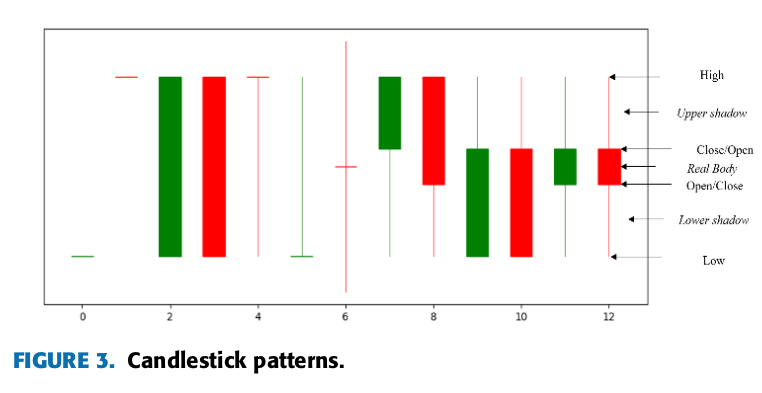
**classes:**  
0.

1.
2. CDLMARUBOZU - -100
3. CDLMARUBOZU - 100
4. CDLDOJI, 100, 收盤價 = 最高價
5. CDLDOJI, -100, 收盤價 = 最低價
6. CDLDOJI, 100, except 4 and 5
7. CDLHAMMER, -100 開盤價 = 最高價
8. CDLHAMMER, 100 收盤價 = 最高價
9. CDLINVERTEDHAMMER, -100 收盤價 = 最低價
10. CDLINVERTEDHAMMER, 100 開盤價 = 最低價
11. CDLSHORTLINE, CDLLONGLINE, -100
12. CDLSHORTLINE, CDLLONGLINE, 100


In [161]:
import pandas_ta

# Category
with show_more_rows():
    display(pandas_ta.Category["momentum"])
help(pandas_ta.ema)

['ao',
 'apo',
 'bias',
 'bop',
 'brar',
 'cci',
 'cfo',
 'cg',
 'cmo',
 'coppock',
 'cti',
 'er',
 'eri',
 'fisher',
 'inertia',
 'kdj',
 'kst',
 'macd',
 'mom',
 'pgo',
 'ppo',
 'psl',
 'pvo',
 'qqe',
 'roc',
 'rsi',
 'rsx',
 'rvgi',
 'slope',
 'smi',
 'squeeze',
 'squeeze_pro',
 'stc',
 'stoch',
 'stochrsi',
 'td_seq',
 'trix',
 'tsi',
 'uo',
 'willr']

Help on function ema in module pandas_ta.overlap.ema:

ema(close, length=None, talib=None, offset=None, **kwargs)
    Exponential Moving Average (EMA)
    
    The Exponential Moving Average is more responsive moving average compared to the
    Simple Moving Average (SMA).  The weights are determined by alpha which is
    proportional to it's length.  There are several different methods of calculating
    EMA.  One method uses just the standard definition of EMA and another uses the
    SMA to generate the initial value for the rest of the calculation.
    
    Sources:
        https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:moving_averages
        https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    
    Calculation:
        Default Inputs:
            length=10, adjust=False, sma=True
        if sma:
            sma_nth = close[0:length].sum() / length
            close[:length - 1] = n

In [164]:
if "eri_strategy" in sys.modules:
    print("delete eri_strategy")
    del sys.modules["eri_strategy"]
import eri_strategy

prefix = ""
suffix = ""
fast = 5
slow = 10
df = stks_data[4].tick_data

import eri_strategy

# adjusted_OHLV = to_adjusted(df)
# display(df.ta.ema(length=13))
# eri_strategy.create_buy_sell_signals(
#     adjusted_OHLV,
#     high="Adj High",
#     low="Adj Low",
#     close="Adj Close",
#     length=13,
#     prefix="c",
#     suffix="m",
# )

data = pd.DataFrame(index=df.index)
data["close"] = df["Close"]
data["p_close"] = df["Close"].shift(1)
data[["bull", "bear"]] = df.ta.eri()
data["ema"] = df.ta.ema(length=13)
display(df.ta.ema(length=13))
data["p_ema"] = data["ema"].shift(1)
data["p_bull"] = data["bull"].shift(1)
data["p_bear"] = data["bear"].shift(1)

data["ERI_BULL"] = 0
data["ERI_BEAR"] = 0

"""
The market price (EMA) is going up.
The Bear Power is negative (below zero), but going up.
The current Bull Power bar is higher than the previous bar.
The Bear Power indicator shows a bullish divergence with the market price. This means the indicator goes up and the price down.
"""
data.loc[
    (data["ema"] > data["p_ema"])
    & (data["bear"] < 0)
    & (data["bear"] > data["p_bear"])
    & (data["bull"] > data["p_bull"])
    & (data["close"] < data["p_close"]),
    "ERI_BULL",
] = 1
"""
The market price (EMA) is going up.
The Bull Power is positive (above zero), but going down.
The current Bear Power bar is lower than the previous bar.
The Bull Power shows a bearish divergence with the market price. This means the indicator goes down and the market price goes up
"""
data.loc[
    (data["ema"] > data["p_ema"])
    & (data["bull"] > 0)
    & (data["bull"] < data["p_bull"])
    & (data["bear"] < data["p_bear"])
    & (data["close"] > data["p_close"]),
    "ERI_BEAR",
] = 1

with show_more_rows():
    display(data.head(100))

# # data = data.dropna()

# # buy_sell_signals = pd.DataFrame(index=df.index)
# # buy_sell_signals[f"{prefix}CTI_BULL{suffix}"] = data["CTI_BULL"]
# # buy_sell_signals[f"{prefix}CTI_BEAR{suffix}"] = data["CTI_BEAR"]
# with show_more_rows():
#     display(data.head(100))

delete eri_strategy


Date
2014-01-02       NaN
2014-01-03       NaN
2014-01-06       NaN
2014-01-07       NaN
2014-01-08       NaN
               ...  
2023-12-22   194.601
2023-12-26   194.379
2023-12-27   194.203
2023-12-28   194.114
2023-12-29   193.888
Name: EMA_13, Length: 2516, dtype: float64

,close,p_close,bull,bear,ema,p_ema,p_bull,p_bear,ERI_BULL,ERI_BEAR
Date,,,,,,,,,,
2014-01-02,19.755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2014-01-03,19.321,19.755,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2014-01-06,19.426,19.321,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2014-01-07,19.287,19.426,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2014-01-08,19.409,19.287,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2014-01-09,19.161,19.409,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2014-01-10,19.034,19.161,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2014-01-13,19.133,19.034,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2014-01-14,19.514,19.133,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [163]:
if "candle_signal" in sys.modules:
    print("delete candle_signal module")
    del sys.modules["candle_signal"]
from candle_signal import create_candle_signals

if "eight_trigrams" in sys.modules:
    print("delete eight_trigrams module")
    del sys.modules["eight_trigrams"]
from eight_trigrams import create_trigrams

if "awesome_oscillator" in sys.modules:
    print("delete awesome_oscillator module")
    del sys.modules["awesome_oscillator"]
from awesome_oscillator import detect_awesome_saucers

if "macd_strategy" in sys.modules:
    print("delete macd_strategy")
    del sys.modules["macd_strategy"]
import macd_strategy

if "cti_strategy" in sys.modules:
    print("delete cti_strategy")
    del sys.modules["cti_strategy"]
import cti_strategy

if "er_strategy" in sys.modules:
    print("delete er_strategy")
    del sys.modules["er_strategy"]
import er_strategy

if "eri_strategy" in sys.modules:
    print("delete eri_strategy")
    del sys.modules["eri_strategy"]
import eri_strategy

import pandas_ta as ta


stk_data = stks_data[4].tick_data
short_ind = 5
long_ind = 10

adjusted_OHLV = to_adjusted(stk_data)

data = pd.concat(
    [
        eri_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            length=13,
            prefix="c",
            suffix="m",
        ),
        er_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            close="Adj Close",
            prefix="c",
            suffix="m",
        ),
        adjusted_OHLV.ta.er(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        cti_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            close="Adj Close",
            fast=5,
            slow=10,
            prefix="c",
            suffix="m",
        ),
        adjusted_OHLV.ta.cti(
            close="Adj Close",
            length=5,
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.cti(
            close="Adj Close",
            length=10,
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.cfo(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.stochrsi(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.cmo(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.rsi(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.stoch(
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.rvi(
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="f",
            suffix="v",
        ),
        adjusted_OHLV.ta.mfi(
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            volume="Adj Volume",
            prefix="f",
            suffix="m",
        ),
        macd_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            close="Adj Close",
            fast=12,
            slow=26,
            signal=9,
            prefix="c",
            suffix="m",
        ),
        adjusted_OHLV.ta.brar(
            open="Adj Open",
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            scalar=1,
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.bop(
            open="Adj Open",
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.bias(close="Adj Close", prefix="f", suffix="m"),
        detect_awesome_saucers(
            adjusted_OHLV, high="Adj High", low="Adj Low", prefix="c", suffix="m"
        ),
        create_trigrams(
            adjusted_OHLV,
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="c",
            suffix="t",
        ),
        create_candle_signals(
            adjusted_OHLV,
            open="Adj Open",
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="c",
            suffix="c",
        ),
    ],
    axis=1,
)

with show_more_rows():
    display(data.head(100))

data = data.dropna()
display(data)

"""
# OVERLAP INDICATORS
data = pd.DataFrame()
# data["ma"] = tb.MA(df["Close"], timeperiod=short_ind)
# data["ema"] = tb.EMA(df["Close"], timeperiod=long_ind)
# data["dema"] = tb.DEMA(df["Close"], timeperiod=short_ind)
# data["kama"] = tb.KAMA(df["Close"], timeperiod=short_ind)
# data["sma"] = tb.SMA(df["Close"], timeperiod=long_ind)
# data["sar"] = tb.SAR(df["High"], df["Low"])

# MOMENTUM INDICATORS
data["adx"] = tb.ADX(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
data["cci"] = tb.CCI(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
data["apo"] = tb.APO(df["Close"], fastperiod=long_ind, slowperiod=short_ind)
data["bop"] = tb.BOP(df["Open"], df["High"], df["Low"], df["Close"])
data["macd"], data["macdsignal"], data["macdhist"] = tb.MACD(
    df["Close"], fastperiod=12, slowperiod=26, signalperiod=9
)
data["mfi"] = tb.MFI(
    df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=long_ind
)
data["mom"] = tb.MOM(df["Close"], timeperiod=long_ind)
data["rsi"] = tb.RSI(df["Close"], timeperiod=long_ind)

# # VOLUME INDICATORS
# data["ad"] = tb.AD(df["High"], df["Low"], df["Close"], df["Volume"])
# data["adosc"] = tb.ADOSC(
#     df["High"],
#     df["Low"],
#     df["Close"],
#     df["Volume"],
#     fastperiod=short_ind,
#     slowperiod=long_ind,
# )
# data["obv"] = tb.OBV(df["Close"], df["Volume"])
data["trange"] = tb.TRANGE(df["High"], df["Low"], df["Close"])
data["atr"] = tb.ATR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
data["natr"] = tb.NATR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)

# data.reset_index(drop=True, inplace=True)
display(data)
display(create_trigrams(df))
# TARGET
# data["target"] = df["Close"].pct_change().rolling(avg_days).mean().shift(avg_days)

# data.dropna(inplace=True)

# columns = ["Open", "High", "Volume", "Low", "trigrams", "target"]

# if custom == True:
#     df = create_signals(data=df)
#     columns = columns + [
#         "shortLineCdl",
#         "longLineCdl",
#         "spinningTop",
#         "closingMarubozu",
#     ]

# if "O" in additional:
#     columns = columns + ["ma", "ema", "dema", "kama", "sma", "sar"]
# if "M" in additional:
#     columns = columns + ["adx", "cci", "apo", "bop", "macd", "mfi", "mom", "rsi"]
# if "V" in additional:
#     columns = columns + ["ad", "adosc", "obv", "trange", "atr", "natr"]

# df = df[columns]
"""

delete candle_signal module
delete eight_trigrams module
delete awesome_oscillator module
delete macd_strategy
delete cti_strategy
delete er_strategy
delete eri_strategy
[X] Ooops!!! It's True, the series 'high' was not found in Adj Open, Adj High, Adj Low, Adj Close, Adj Volume
[X] Ooops!!! It's True, the series 'low' was not found in Adj Open, Adj High, Adj Low, Adj Close, Adj Volume


,c_ERI_BULL_m,c_ERI_BEAR_m,c_ER_BULL_m,c_ER_BEAR_m,f_ER_10_m,c_CTI_BULL_m,c_CTI_BEAR_m,f_CTI_5_m,f_CTI_10_m,f_CFO_9_m,f_STOCHRSIk_14_14_3_3_m,f_STOCHRSId_14_14_3_3_m,f_CMO_14_m,f_RSI_14_m,f_STOCHk_14_3_3_m,f_STOCHd_14_3_3_m,f_RVI_14_v,f_MFI_14_m,c_CORSSOVER_BULL_m,c_CORSSOVER_BEAR_m,c_ZERO_CORSSING_BULL_m,c_ZERO_CORSSING_BEAR_m,f_AR_26_m,f_BR_26_m,f_BOP_m,f_BIAS_SMA_26_m,c_SAUCERS_BULL_m,c_SAUCERS_BEAR_m,c_BullishHarami_t,c_BullishHorn_t,c_BullishHigh_t,c_BullishLow_t,c_BearHarami_t,c_BearHorn_t,c_BearHigh_t,c_BearLow_t,c_CDL3LINESTRIKE_BULL_c,c_CDL3LINESTRIKE_BEAR_c,c_CDL3BLACKCROWS_BULL_c,c_CDL3BLACKCROWS_BEAR_c,c_CDLEVENINGSTAR_BULL_c,c_CDLEVENINGSTAR_BEAR_c,c_CDLTASUKIGAP_BULL_c,c_CDLTASUKIGAP_BEAR_c,c_CDLINVERTEDHAMMER_BULL_c,c_CDLINVERTEDHAMMER_BEAR_c,c_CDLMATCHINGLOW_BULL_c,c_CDLMATCHINGLOW_BEAR_c,c_CDLABANDONEDBABY_BULL_c,c_CDLABANDONEDBABY_BEAR_c,c_CDLBREAKAWAY_BULL_c,c_CDLBREAKAWAY_BEAR_c,c_CDLMORNINGSTAR_BULL_c,c_CDLMORNINGSTAR_BEAR_c,c_CDLPIERCING_BULL_c,c_CDLPIERCING_BEAR_c,c_CDLSTICKSANDWICH_BULL_c,c_CDLSTICKSANDWICH_BEAR_c,c_CDLTHRUSTING_BULL_c,c_CDLTHRUSTING_BEAR_c,c_CDLCOUNTERATTACK_BEAR_c,c_CDLCOUNTERATTACK_BULL_c,c_CDLINNECK_BULL_c,c_CDLINNECK_BEAR_c,c_CDL3INSIDE_BULL_c,c_CDL3INSIDE_BEAR_c,c_CDLHOMINGPIGEON_BULL_c,c_CDLHOMINGPIGEON_BEAR_c,c_CDLDARKCLOUDCOVER_BULL_c,c_CDLDARKCLOUDCOVER_BEAR_c,c_CDLIDENTICAL3CROWS_BULL_c,c_CDLIDENTICAL3CROWS_BEAR_c,c_CDLMORNINGDOJISTAR_BULL_c,c_CDLMORNINGDOJISTAR_BEAR_c,c_CDLXSIDEGAP3METHODS_BULL_c,c_CDLXSIDEGAP3METHODS_BEAR_c,c_CDLTRISTAR_BULL_c,c_CDLTRISTAR_BEAR_c,c_CDLGAPSIDESIDEWHITE_BULL_c,c_CDLGAPSIDESIDEWHITE_BEAR_c,c_CDLEVENINGDOJISTAR_BULL_c,c_CDLEVENINGDOJISTAR_BEAR_c,c_CDL3WHITESOLDIERS_BULL_c,c_CDL3WHITESOLDIERS_BEAR_c,c_CDLONNECK_BULL_c,c_CDLONNECK_BEAR_c,c_CDL3OUTSIDE_BULL_c,c_CDL3OUTSIDE_BEAR_c,c_CDLRICKSHAWMAN_BULL_c,c_CDLRICKSHAWMAN_BEAR_c,c_CDLSEPARATINGLINES_BULL_c,c_CDLSEPARATINGLINES_BEAR_c,c_CDLLONGLEGGEDDOJI_BULL_c,c_CDLLONGLEGGEDDOJI_BEAR_c,c_CDLHARAMI_BULL_c,c_CDLHARAMI_BEAR_c,c_CDLLADDERBOTTOM_BULL_c,c_CDLLADDERBOTTOM_BEAR_c,c_CDLCLOSINGMARUBOZU_BULL_c,c_CDLCLOSINGMARUBOZU_BEAR_c,c_CDLTAKURI_BULL_c,c_CDLTAKURI_BEAR_c,c_CDLDOJISTAR_BULL_c,c_CDLDOJISTAR_BEAR_c,c_CDLHARAMICROSS_BULL_c,c_CDLHARAMICROSS_BEAR_c,c_CDLADVANCEBLOCK_BULL_c,c_CDLADVANCEBLOCK_BEAR_c,c_CDLSHOOTINGSTAR_BULL_c,c_CDLSHOOTINGSTAR_BEAR_c,c_CDLMARUBOZU_BULL_c,c_CDLMARUBOZU_BEAR_c,c_CDLUNIQUE3RIVER_BULL_c,c_CDLUNIQUE3RIVER_BEAR_c,c_CDL2CROWS_BULL_c,c_CDL2CROWS_BEAR_c,c_CDLBELTHOLD_BULL_c,c_CDLBELTHOLD_BEAR_c,c_CDLHAMMER_BULL_c,c_CDLHAMMER_BEAR_c,c_CDLSHORTLINE_BULL_c,c_CDLSHORTLINE_BEAR_c,c_CDLHIGHWAVE_BULL_c,c_CDLHIGHWAVE_BEAR_c,c_CDLLONGLINE_BULL_c,c_CDLLONGLINE_BEAR_c,c_CDLSPINNINGTOP_BULL_c,c_CDLSPINNINGTOP_BEAR_c,c_CDLUPSIDEGAP2CROWS_BULL_c,c_CDLUPSIDEGAP2CROWS_BEAR_c,c_CDLGRAVESTONEDOJI_BULL_c,c_CDLGRAVESTONEDOJI_BEAR_c,c_CDLHIKKAKEMOD_BULL_c,c_CDLHIKKAKEMOD_BEAR_c,c_CDLHIKKAKE_BULL_c,c_CDLHIKKAKE_BEAR_c,c_CDLENGULFING_BULL_c,c_CDLENGULFING_BEAR_c,c_CDLMATHOLD_BULL_c,c_CDLMATHOLD_BEAR_c,c_CDLHANGINGMAN_BULL_c,c_CDLHANGINGMAN_BEAR_c,c_CDLSTALLEDPATTERN_BULL_c,c_CDLSTALLEDPATTERN_BEAR_c,c_CDLRISEFALL3METHODS_BULL_c,c_CDLRISEFALL3METHODS_BEAR_c,c_CDLKICKING_BULL_c,c_CDLKICKING_BEAR_c,c_CDLDRAGONFLYDOJI_BULL_c,c_CDLDRAGONFLYDOJI_BEAR_c,c_CDLCONCEALBABYSWALL_BULL_c,c_CDLCONCEALBABYSWALL_BEAR_c,c_CDLKICKINGBYLENGTH_BEAR_c,c_CDLKICKINGBYLENGTH_BULL_c,c_CDL3STARSINSOUTH_BULL_c,c_CDL3STARSINSOUTH_BEAR_c,c_CDLDOJI_BULL_c,c_CDLDOJI_BEAR_c
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

,c_ERI_BULL_m,c_ERI_BEAR_m,c_ER_BULL_m,c_ER_BEAR_m,f_ER_10_m,c_CTI_BULL_m,c_CTI_BEAR_m,f_CTI_5_m,f_CTI_10_m,f_CFO_9_m,f_STOCHRSIk_14_14_3_3_m,f_STOCHRSId_14_14_3_3_m,f_CMO_14_m,f_RSI_14_m,f_STOCHk_14_3_3_m,f_STOCHd_14_3_3_m,f_RVI_14_v,f_MFI_14_m,c_CORSSOVER_BULL_m,c_CORSSOVER_BEAR_m,c_ZERO_CORSSING_BULL_m,c_ZERO_CORSSING_BEAR_m,f_AR_26_m,f_BR_26_m,f_BOP_m,f_BIAS_SMA_26_m,c_SAUCERS_BULL_m,c_SAUCERS_BEAR_m,c_BullishHarami_t,c_BullishHorn_t,c_BullishHigh_t,c_BullishLow_t,c_BearHarami_t,c_BearHorn_t,c_BearHigh_t,c_BearLow_t,c_CDL3LINESTRIKE_BULL_c,c_CDL3LINESTRIKE_BEAR_c,c_CDL3BLACKCROWS_BULL_c,c_CDL3BLACKCROWS_BEAR_c,c_CDLEVENINGSTAR_BULL_c,c_CDLEVENINGSTAR_BEAR_c,c_CDLTASUKIGAP_BULL_c,c_CDLTASUKIGAP_BEAR_c,c_CDLINVERTEDHAMMER_BULL_c,c_CDLINVERTEDHAMMER_BEAR_c,c_CDLMATCHINGLOW_BULL_c,c_CDLMATCHINGLOW_BEAR_c,c_CDLABANDONEDBABY_BULL_c,c_CDLABANDONEDBABY_BEAR_c,c_CDLBREAKAWAY_BULL_c,c_CDLBREAKAWAY_BEAR_c,c_CDLMORNINGSTAR_BULL_c,c_CDLMORNINGSTAR_BEAR_c,c_CDLPIERCING_BULL_c,c_CDLPIERCING_BEAR_c,c_CDLSTICKSANDWICH_BULL_c,c_CDLSTICKSANDWICH_BEAR_c,c_CDLTHRUSTING_BULL_c,c_CDLTHRUSTING_BEAR_c,c_CDLCOUNTERATTACK_BEAR_c,c_CDLCOUNTERATTACK_BULL_c,c_CDLINNECK_BULL_c,c_CDLINNECK_BEAR_c,c_CDL3INSIDE_BULL_c,c_CDL3INSIDE_BEAR_c,c_CDLHOMINGPIGEON_BULL_c,c_CDLHOMINGPIGEON_BEAR_c,c_CDLDARKCLOUDCOVER_BULL_c,c_CDLDARKCLOUDCOVER_BEAR_c,c_CDLIDENTICAL3CROWS_BULL_c,c_CDLIDENTICAL3CROWS_BEAR_c,c_CDLMORNINGDOJISTAR_BULL_c,c_CDLMORNINGDOJISTAR_BEAR_c,c_CDLXSIDEGAP3METHODS_BULL_c,c_CDLXSIDEGAP3METHODS_BEAR_c,c_CDLTRISTAR_BULL_c,c_CDLTRISTAR_BEAR_c,c_CDLGAPSIDESIDEWHITE_BULL_c,c_CDLGAPSIDESIDEWHITE_BEAR_c,c_CDLEVENINGDOJISTAR_BULL_c,c_CDLEVENINGDOJISTAR_BEAR_c,c_CDL3WHITESOLDIERS_BULL_c,c_CDL3WHITESOLDIERS_BEAR_c,c_CDLONNECK_BULL_c,c_CDLONNECK_BEAR_c,c_CDL3OUTSIDE_BULL_c,c_CDL3OUTSIDE_BEAR_c,c_CDLRICKSHAWMAN_BULL_c,c_CDLRICKSHAWMAN_BEAR_c,c_CDLSEPARATINGLINES_BULL_c,c_CDLSEPARATINGLINES_BEAR_c,c_CDLLONGLEGGEDDOJI_BULL_c,c_CDLLONGLEGGEDDOJI_BEAR_c,c_CDLHARAMI_BULL_c,c_CDLHARAMI_BEAR_c,c_CDLLADDERBOTTOM_BULL_c,c_CDLLADDERBOTTOM_BEAR_c,c_CDLCLOSINGMARUBOZU_BULL_c,c_CDLCLOSINGMARUBOZU_BEAR_c,c_CDLTAKURI_BULL_c,c_CDLTAKURI_BEAR_c,c_CDLDOJISTAR_BULL_c,c_CDLDOJISTAR_BEAR_c,c_CDLHARAMICROSS_BULL_c,c_CDLHARAMICROSS_BEAR_c,c_CDLADVANCEBLOCK_BULL_c,c_CDLADVANCEBLOCK_BEAR_c,c_CDLSHOOTINGSTAR_BULL_c,c_CDLSHOOTINGSTAR_BEAR_c,c_CDLMARUBOZU_BULL_c,c_CDLMARUBOZU_BEAR_c,c_CDLUNIQUE3RIVER_BULL_c,c_CDLUNIQUE3RIVER_BEAR_c,c_CDL2CROWS_BULL_c,c_CDL2CROWS_BEAR_c,c_CDLBELTHOLD_BULL_c,c_CDLBELTHOLD_BEAR_c,c_CDLHAMMER_BULL_c,c_CDLHAMMER_BEAR_c,c_CDLSHORTLINE_BULL_c,c_CDLSHORTLINE_BEAR_c,c_CDLHIGHWAVE_BULL_c,c_CDLHIGHWAVE_BEAR_c,c_CDLLONGLINE_BULL_c,c_CDLLONGLINE_BEAR_c,c_CDLSPINNINGTOP_BULL_c,c_CDLSPINNINGTOP_BEAR_c,c_CDLUPSIDEGAP2CROWS_BULL_c,c_CDLUPSIDEGAP2CROWS_BEAR_c,c_CDLGRAVESTONEDOJI_BULL_c,c_CDLGRAVESTONEDOJI_BEAR_c,c_CDLHIKKAKEMOD_BULL_c,c_CDLHIKKAKEMOD_BEAR_c,c_CDLHIKKAKE_BULL_c,c_CDLHIKKAKE_BEAR_c,c_CDLENGULFING_BULL_c,c_CDLENGULFING_BEAR_c,c_CDLMATHOLD_BULL_c,c_CDLMATHOLD_BEAR_c,c_CDLHANGINGMAN_BULL_c,c_CDLHANGINGMAN_BEAR_c,c_CDLSTALLEDPATTERN_BULL_c,c_CDLSTALLEDPATTERN_BEAR_c,c_CDLRISEFALL3METHODS_BULL_c,c_CDLRISEFALL3METHODS_BEAR_c,c_CDLKICKING_BULL_c,c_CDLKICKING_BEAR_c,c_CDLDRAGONFLYDOJI_BULL_c,c_CDLDRAGONFLYDOJI_BEAR_c,c_CDLCONCEALBABYSWALL_BULL_c,c_CDLCONCEALBABYSWALL_BEAR_c,c_CDLKICKINGBYLENGTH_BEAR_c,c_CDLKICKINGBYLENGTH_BULL_c,c_CDL3STARSINSOUTH_BULL_c,c_CDL3STARSINSOUTH_BEAR_c,c_CDLDOJI_BULL_c,c_CDLDOJI_BEAR_c
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-02-25,0.000,0.000,0.000,0.000,0.149,0.000,0.000,-0.920,-0.716,-0.428,41.923,54.023,-12.038,43.981,48.665,57.386,46.323,65.745,0.000,0.000,0.000,0.000,1.214,0.851,-0.854,-0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

'\n# OVERLAP INDICATORS\ndata = pd.DataFrame()\n# data["ma"] = tb.MA(df["Close"], timeperiod=short_ind)\n# data["ema"] = tb.EMA(df["Close"], timeperiod=long_ind)\n# data["dema"] = tb.DEMA(df["Close"], timeperiod=short_ind)\n# data["kama"] = tb.KAMA(df["Close"], timeperiod=short_ind)\n# data["sma"] = tb.SMA(df["Close"], timeperiod=long_ind)\n# data["sar"] = tb.SAR(df["High"], df["Low"])\n\n# MOMENTUM INDICATORS\ndata["adx"] = tb.ADX(df["High"], df["Low"], df["Close"], timeperiod=long_ind)\ndata["cci"] = tb.CCI(df["High"], df["Low"], df["Close"], timeperiod=long_ind)\ndata["apo"] = tb.APO(df["Close"], fastperiod=long_ind, slowperiod=short_ind)\ndata["bop"] = tb.BOP(df["Open"], df["High"], df["Low"], df["Close"])\ndata["macd"], data["macdsignal"], data["macdhist"] = tb.MACD(\n    df["Close"], fastperiod=12, slowperiod=26, signalperiod=9\n)\ndata["mfi"] = tb.MFI(\n    df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=long_ind\n)\ndata["mom"] = tb.MOM(df["Close"], timeperiod=long

In [ ]:
def format_data(
    df,
    short_ind=5,
    long_ind=10,
    custom=True,
    trigrams=True,
    patterns=True,
    avg_days=5,
    additional=["O", "M", "V"],
):
    """Takes input features and creates TA indicators, the 8-trigram scheme and Target labels.

    Parameters
    ----------
    df:
        Pandas DataFrame containing Open, High, Low, Close, Volume and Date columns.
    start_time:
        Start time in datetime format when the stock is purchased
    end_time:
        End time in datetime format when the stock is sold
    custom:
        Boolean Value to specify whether to create custom signals or not
    trigrams:
        Boolean value to specify whether to calculate 8 Trigrams or not
    patterns:
        Boolean Value to specify whether to calculate typical candlestick patterns or not
    avg_days:
        Integer denoting the number of days for which rolling average has to be calculated
    additional:
        List containing values O,M,V which specify which additional stock market indicators are to be calculated

    Returns
    ----------
    Pandas DataFrame with columns -
        Updated Open, High, Low and Closing Prices, Volume, Trigrams, Target and optionally Short Line Cdl, Long Line Cdl, Spinning Top and Closing Marubozu (if custom signals are required)
    """
    import talib as tb

    # OVERLAP INDICATORS

    data = pd.DataFrame()
    data["ma"] = tb.MA(df["Close"], timeperiod=short_ind)
    data["ema"] = tb.EMA(df["Close"], timeperiod=long_ind)
    data["dema"] = tb.DEMA(df["Close"], timeperiod=short_ind)
    data["kama"] = tb.KAMA(df["Close"], timeperiod=short_ind)
    data["sma"] = tb.SMA(df["Close"], timeperiod=long_ind)
    data["sar"] = tb.SAR(df["High"], df["Low"])

    # MOMENTUM INDICATORS
    data["adx"] = tb.ADX(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
    data["cci"] = tb.CCI(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
    data["apo"] = tb.APO(df["Close"], fastperiod=long_ind, slowperiod=short_ind)
    data["bop"] = tb.BOP(df["Open"], df["High"], df["Low"], df["Close"])
    data["macd"], data["macdsignal"], data["macdhist"] = tb.MACD(
        df["Close"], fastperiod=12, slowperiod=26, signalperiod=9
    )
    data["mfi"] = tb.MFI(
        df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=long_ind
    )
    data["mom"] = tb.MOM(df["Close"], timeperiod=long_ind)
    data["rsi"] = tb.RSI(df["Close"], timeperiod=long_ind)

    # VOLUME INDICATORS
    data["ad"] = tb.AD(df["High"], df["Low"], df["Close"], df["Volume"])
    data["adosc"] = tb.ADOSC(
        df["High"],
        df["Low"],
        df["Close"],
        df["Volume"],
        fastperiod=short_ind,
        slowperiod=long_ind,
    )
    data["obv"] = tb.OBV(df["Close"], df["Volume"])
    data["trange"] = tb.TRANGE(df["High"], df["Low"], df["Close"])
    data["atr"] = tb.ATR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
    data["natr"] = tb.NATR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)

    # data.reset_index(drop=True, inplace=True)

    create_trigrams(df)
    # TARGET
    data["target"] = df["Close"].pct_change().rolling(avg_days).mean().shift(avg_days)

    data.dropna(inplace=True)

    columns = ["Open", "High", "Volume", "Low", "trigrams", "target"]

    if custom == True:
        df = create_signals(data=df)
        columns = columns + [
            "shortLineCdl",
            "longLineCdl",
            "spinningTop",
            "closingMarubozu",
        ]

    if "O" in additional:
        columns = columns + ["ma", "ema", "dema", "kama", "sma", "sar"]
    if "M" in additional:
        columns = columns + ["adx", "cci", "apo", "bop", "macd", "mfi", "mom", "rsi"]
    if "V" in additional:
        columns = columns + ["ad", "adosc", "obv", "trange", "atr", "natr"]

    df = df[columns]

    return df

In [ ]:
df = stks_data[4].tick_data
display(
    create_trigrams(
        to_adjusted(df),
        high="Adj High",
        low="Adj Low",
        close="Adj Close",
        prefix="c",
        suffix="B",
    )
)

,c_BullishHarami_B,c_BullishHorn_B,c_BullishHigh_B,c_BullishLow_B,c_BearHarami_B,c_BearHorn_B,c_BearHigh_B,c_BearLow_B
Date,,,,,,,,
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
2014-01-07,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
2014-01-08,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2014-01-09,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
...,...,...,...,...,...,...,...,...
2023-12-22,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
2023-12-26,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
2023-12-27,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000


In [ ]:
ta.get_function_groups()

{'Cycle Indicators': ['HT_DCPERIOD',
  'HT_DCPHASE',
  'HT_PHASOR',
  'HT_SINE',
  'HT_TRENDMODE'],
 'Math Operators': ['ADD',
  'DIV',
  'MAX',
  'MAXINDEX',
  'MIN',
  'MININDEX',
  'MINMAX',
  'MINMAXINDEX',
  'MULT',
  'SUB',
  'SUM'],
 'Math Transform': ['ACOS',
  'ASIN',
  'ATAN',
  'CEIL',
  'COS',
  'COSH',
  'EXP',
  'FLOOR',
  'LN',
  'LOG10',
  'SIN',
  'SINH',
  'SQRT',
  'TAN',
  'TANH'],
 'Momentum Indicators': ['ADX',
  'ADXR',
  'APO',
  'AROON',
  'AROONOSC',
  'BOP',
  'CCI',
  'CMO',
  'DX',
  'MACD',
  'MACDEXT',
  'MACDFIX',
  'MFI',
  'MINUS_DI',
  'MINUS_DM',
  'MOM',
  'PLUS_DI',
  'PLUS_DM',
  'PPO',
  'ROC',
  'ROCP',
  'ROCR',
  'ROCR100',
  'RSI',
  'STOCH',
  'STOCHF',
  'STOCHRSI',
  'TRIX',
  'ULTOSC',
  'WILLR'],
 'Overlap Studies': ['BBANDS',
  'DEMA',
  'EMA',
  'HT_TRENDLINE',
  'KAMA',
  'MA',
  'MAMA',
  'MAVP',
  'MIDPOINT',
  'MIDPRICE',
  'SAR',
  'SAREXT',
  'SMA',
  'T3',
  'TEMA',
  'TRIMA',
  'WMA'],
 'Pattern Recognition': ['CDL2CROWS',
  'C

In [ ]:
from itertools import compress

df = stks_data[4].tick_data
candle_names = ta.get_function_groups()["Pattern Recognition"]
# display(candle_names)
op = df["Open"]
hi = df["High"]
lo = df["Low"]
cl = df["Close"]

candle_values = pd.DataFrame(index=df.index)
for candle in candle_names:
    candle_values[candle] = getattr(ta, candle)(op, hi, lo, cl)

# display(candle_values.head(10))
candle_values["candlestick_pattern"] = np.nan
candle_values["candlestick_match_count"] = np.nan
row = candle_values.iloc[5, :]
# display(type(row))
candle_bull_signals = row[candle_names].values > 0
candle_bear_signals = row[candle_names].values < 0
candle_signals = row[candle_names].values != 0
# display(sum(candle_bull_signals) + sum(candle_bear_signals))

signal_name = list(compress(row[candle_names].keys(), candle_signals))[0]

# display(candle_bull_signals)
display(signal_name)
display(type(row))
display(row)
display(type(row[signal_name]))
display(row[signal_name])
if row[signal_name] > 0:
    display("bull")
else:
    display("bear")
"""
for index, row in candle_values.iterrows():
    display(row)
    candle_bull_signals = row[candle_names] > 0
    candle_bear_signals = row[candle_names] < 0
    found_pattern = sum(candle_bull_signals) + sum(candle_bear_signals)
    # no pattern found
    if found_pattern == 0:
        candle_values.loc[index, "candlestick_pattern"] = "NO_PATTERN"
        candle_values.loc[index, "candlestick_match_count"] = 0
    # single pattern found
    elif found_pattern == 1:
        # bull pattern 100 or 200
        signal_name = compress(row[candle_names].keys(), candle_bull_signals or  candle_bear_signals)
        display(signal_name)
        break
"""

'CDLENGULFING'

pandas.core.series.Series

CDL2CROWS                 0.000
CDL3BLACKCROWS            0.000
CDL3INSIDE                0.000
CDL3LINESTRIKE            0.000
CDL3OUTSIDE               0.000
                           ... 
CDLUNIQUE3RIVER           0.000
CDLUPSIDEGAP2CROWS        0.000
CDLXSIDEGAP3METHODS       0.000
candlestick_pattern         NaN
candlestick_match_count     NaN
Name: 2014-01-09, Length: 63, dtype: float64

numpy.float64

-100.0

'bear'

'\nfor index, row in candle_values.iterrows():\n    display(row)\n    candle_bull_signals = row[candle_names] > 0\n    candle_bear_signals = row[candle_names] < 0\n    found_pattern = sum(candle_bull_signals) + sum(candle_bear_signals)\n    # no pattern found\n    if found_pattern == 0:\n        candle_values.loc[index, "candlestick_pattern"] = "NO_PATTERN"\n        candle_values.loc[index, "candlestick_match_count"] = 0\n    # single pattern found\n    elif found_pattern == 1:\n        # bull pattern 100 or 200\n        signal_name = compress(row[candle_names].keys(), candle_bull_signals or  candle_bear_signals)\n        display(signal_name)\n        break\n'

In [ ]:
from itertools import compress
from candle_rankings import candle_rankings
from sklearn.preprocessing import OneHotEncoder
from MyPyUtil.util import ivmin


def create_candle_signals(
    df, open="Open", high="High", low="Low", close="Close", prefix="", suffix=""
):

    if len(prefix) > 0:
        prefix = prefix + "_"
    if len(suffix) > 0:
        suffix = "_" + suffix

    candle_names = ta.get_function_groups()["Pattern Recognition"]

    op = df[open]
    hi = df[high]
    lo = df[low]
    cl = df[close]

    candle_values = pd.DataFrame(index=df.index)
    for candle in candle_names:
        candle_values[candle] = getattr(ta, candle)(op, hi, lo, cl)

    candle_values["candlestick_pattern"] = np.nan
    candle_values["candlestick_match_count"] = np.nan

    to_pattern_name = lambda row, signal_name: signal_name + (
        "_BULL" if row[signal_name] > 0 else "_BEAR"
    )
    for index, row in candle_values.iterrows():
        candle_signals = row[candle_names].values != 0
        found_pattern = sum(candle_signals)
        # no pattern found
        if found_pattern == 0:
            candle_values.loc[index, "candlestick_pattern"] = "NO_PATTERN"
            candle_values.loc[index, "candlestick_match_count"] = 0
        # single pattern found
        elif found_pattern == 1:
            # bull pattern 100 or 200
            signal_name = list(compress(row[candle_names].keys(), candle_signals))[0]
            candle_values.loc[index, "candlestick_pattern"] = to_pattern_name(
                row, signal_name
            )
            candle_values.loc[index, "candlestick_match_count"] = 1
        # multiple patterns matched -- select best performance
        else:
            # filter out pattern names from bool list of values
            signals_name = list(compress(row[candle_names].keys(), candle_signals))
            patterns_name = [
                to_pattern_name(row, signal_name) for signal_name in signals_name
            ]
            ranks_list = [
                candle_rankings[pattern_name] for pattern_name in patterns_name
            ]
            rank_index_best, _ = ivmin(ranks_list)
            candle_values.loc[index, "candlestick_pattern"] = patterns_name[
                rank_index_best
            ]
            candle_values.loc[index, "candlestick_match_count"] = len(patterns_name)

    ohe_categories = [list(candle_rankings.keys())]
    ohe_columns = ["candlestick_pattern"]
    enc = OneHotEncoder(
        sparse_output=False,
        categories=ohe_categories,
        handle_unknown="ignore",
        dtype=int,
    )
    transformed_df = pd.DataFrame(
        enc.fit_transform(candle_values[ohe_columns]),
        columns=enc.get_feature_names_out(),
        index=candle_values.index,
    )
    start_pos = len("candlestick_pattern") + 1
    transformed_df.columns = [
        f"{prefix}{name[start_pos:]}{suffix}" for name in transformed_df.columns
    ]

    return transformed_df

In [ ]:
df = stks_data[4].tick_data
candle_signals = create_candle_signals(df)
candle_signals

,CDL3LINESTRIKE_BULL,CDL3LINESTRIKE_BEAR,CDL3BLACKCROWS_BULL,CDL3BLACKCROWS_BEAR,CDLEVENINGSTAR_BULL,CDLEVENINGSTAR_BEAR,CDLTASUKIGAP_BULL,CDLTASUKIGAP_BEAR,CDLINVERTEDHAMMER_BULL,CDLINVERTEDHAMMER_BEAR,CDLMATCHINGLOW_BULL,CDLMATCHINGLOW_BEAR,CDLABANDONEDBABY_BULL,CDLABANDONEDBABY_BEAR,CDLBREAKAWAY_BULL,CDLBREAKAWAY_BEAR,CDLMORNINGSTAR_BULL,CDLMORNINGSTAR_BEAR,CDLPIERCING_BULL,CDLPIERCING_BEAR,CDLSTICKSANDWICH_BULL,CDLSTICKSANDWICH_BEAR,CDLTHRUSTING_BULL,CDLTHRUSTING_BEAR,CDLCOUNTERATTACK_BEAR,CDLCOUNTERATTACK_BULL,CDLINNECK_BULL,CDLINNECK_BEAR,CDL3INSIDE_BULL,CDL3INSIDE_BEAR,CDLHOMINGPIGEON_BULL,CDLHOMINGPIGEON_BEAR,CDLDARKCLOUDCOVER_BULL,CDLDARKCLOUDCOVER_BEAR,CDLIDENTICAL3CROWS_BULL,CDLIDENTICAL3CROWS_BEAR,CDLMORNINGDOJISTAR_BULL,CDLMORNINGDOJISTAR_BEAR,CDLXSIDEGAP3METHODS_BULL,CDLXSIDEGAP3METHODS_BEAR,CDLTRISTAR_BULL,CDLTRISTAR_BEAR,CDLGAPSIDESIDEWHITE_BULL,CDLGAPSIDESIDEWHITE_BEAR,CDLEVENINGDOJISTAR_BULL,CDLEVENINGDOJISTAR_BEAR,CDL3WHITESOLDIERS_BULL,CDL3WHITESOLDIERS_BEAR,CDLONNECK_BULL,CDLONNECK_BEAR,CDL3OUTSIDE_BULL,CDL3OUTSIDE_BEAR,CDLRICKSHAWMAN_BULL,CDLRICKSHAWMAN_BEAR,CDLSEPARATINGLINES_BULL,CDLSEPARATINGLINES_BEAR,CDLLONGLEGGEDDOJI_BULL,CDLLONGLEGGEDDOJI_BEAR,CDLHARAMI_BULL,CDLHARAMI_BEAR,CDLLADDERBOTTOM_BULL,CDLLADDERBOTTOM_BEAR,CDLCLOSINGMARUBOZU_BULL,CDLCLOSINGMARUBOZU_BEAR,CDLTAKURI_BULL,CDLTAKURI_BEAR,CDLDOJISTAR_BULL,CDLDOJISTAR_BEAR,CDLHARAMICROSS_BULL,CDLHARAMICROSS_BEAR,CDLADVANCEBLOCK_BULL,CDLADVANCEBLOCK_BEAR,CDLSHOOTINGSTAR_BULL,CDLSHOOTINGSTAR_BEAR,CDLMARUBOZU_BULL,CDLMARUBOZU_BEAR,CDLUNIQUE3RIVER_BULL,CDLUNIQUE3RIVER_BEAR,CDL2CROWS_BULL,CDL2CROWS_BEAR,CDLBELTHOLD_BULL,CDLBELTHOLD_BEAR,CDLHAMMER_BULL,CDLHAMMER_BEAR,CDLSHORTLINE_BULL,CDLSHORTLINE_BEAR,CDLHIGHWAVE_BULL,CDLHIGHWAVE_BEAR,CDLLONGLINE_BULL,CDLLONGLINE_BEAR,CDLSPINNINGTOP_BULL,CDLSPINNINGTOP_BEAR,CDLUPSIDEGAP2CROWS_BULL,CDLUPSIDEGAP2CROWS_BEAR,CDLGRAVESTONEDOJI_BULL,CDLGRAVESTONEDOJI_BEAR,CDLHIKKAKEMOD_BULL,CDLHIKKAKEMOD_BEAR,CDLHIKKAKE_BULL,CDLHIKKAKE_BEAR,CDLENGULFING_BULL,CDLENGULFING_BEAR,CDLMATHOLD_BULL,CDLMATHOLD_BEAR,CDLHANGINGMAN_BULL,CDLHANGINGMAN_BEAR,CDLSTALLEDPATTERN_BULL,CDLSTALLEDPATTERN_BEAR,CDLRISEFALL3METHODS_BULL,CDLRISEFALL3METHODS_BEAR,CDLKICKING_BULL,CDLKICKING_BEAR,CDLDRAGONFLYDOJI_BULL,CDLDRAGONFLYDOJI_BEAR,CDLCONCEALBABYSWALL_BULL,CDLCONCEALBABYSWALL_BEAR,CDLKICKINGBYLENGTH_BEAR,CDLKICKINGBYLENGTH_BULL,CDL3STARSINSOUTH_BULL,CDL3STARSINSOUTH_BEAR,CDLDOJI_BULL,CDLDOJI_BEAR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
df = stks_data[4].tick_data
candle_signals, candle_values = create_candle_signals(df, prefix="c", suffix="candle")
candle_signals

ValueError: too many values to unpack (expected 2)

In [ ]:
candle_signals[(candle_signals != 0).sum(axis=1) > 0]

,CDL3LINESTRIKE_BULL,CDL3LINESTRIKE_BEAR,CDL3BLACKCROWS_BULL,CDL3BLACKCROWS_BEAR,CDLEVENINGSTAR_BULL,CDLEVENINGSTAR_BEAR,CDLTASUKIGAP_BULL,CDLTASUKIGAP_BEAR,CDLINVERTEDHAMMER_BULL,CDLINVERTEDHAMMER_BEAR,CDLMATCHINGLOW_BULL,CDLMATCHINGLOW_BEAR,CDLABANDONEDBABY_BULL,CDLABANDONEDBABY_BEAR,CDLBREAKAWAY_BULL,CDLBREAKAWAY_BEAR,CDLMORNINGSTAR_BULL,CDLMORNINGSTAR_BEAR,CDLPIERCING_BULL,CDLPIERCING_BEAR,CDLSTICKSANDWICH_BULL,CDLSTICKSANDWICH_BEAR,CDLTHRUSTING_BULL,CDLTHRUSTING_BEAR,CDLCOUNTERATTACK_BEAR,CDLCOUNTERATTACK_BULL,CDLINNECK_BULL,CDLINNECK_BEAR,CDL3INSIDE_BULL,CDL3INSIDE_BEAR,CDLHOMINGPIGEON_BULL,CDLHOMINGPIGEON_BEAR,CDLDARKCLOUDCOVER_BULL,CDLDARKCLOUDCOVER_BEAR,CDLIDENTICAL3CROWS_BULL,CDLIDENTICAL3CROWS_BEAR,CDLMORNINGDOJISTAR_BULL,CDLMORNINGDOJISTAR_BEAR,CDLXSIDEGAP3METHODS_BULL,CDLXSIDEGAP3METHODS_BEAR,CDLTRISTAR_BULL,CDLTRISTAR_BEAR,CDLGAPSIDESIDEWHITE_BULL,CDLGAPSIDESIDEWHITE_BEAR,CDLEVENINGDOJISTAR_BULL,CDLEVENINGDOJISTAR_BEAR,CDL3WHITESOLDIERS_BULL,CDL3WHITESOLDIERS_BEAR,CDLONNECK_BULL,CDLONNECK_BEAR,CDL3OUTSIDE_BULL,CDL3OUTSIDE_BEAR,CDLRICKSHAWMAN_BULL,CDLRICKSHAWMAN_BEAR,CDLSEPARATINGLINES_BULL,CDLSEPARATINGLINES_BEAR,CDLLONGLEGGEDDOJI_BULL,CDLLONGLEGGEDDOJI_BEAR,CDLHARAMI_BULL,CDLHARAMI_BEAR,CDLLADDERBOTTOM_BULL,CDLLADDERBOTTOM_BEAR,CDLCLOSINGMARUBOZU_BULL,CDLCLOSINGMARUBOZU_BEAR,CDLTAKURI_BULL,CDLTAKURI_BEAR,CDLDOJISTAR_BULL,CDLDOJISTAR_BEAR,CDLHARAMICROSS_BULL,CDLHARAMICROSS_BEAR,CDLADVANCEBLOCK_BULL,CDLADVANCEBLOCK_BEAR,CDLSHOOTINGSTAR_BULL,CDLSHOOTINGSTAR_BEAR,CDLMARUBOZU_BULL,CDLMARUBOZU_BEAR,CDLUNIQUE3RIVER_BULL,CDLUNIQUE3RIVER_BEAR,CDL2CROWS_BULL,CDL2CROWS_BEAR,CDLBELTHOLD_BULL,CDLBELTHOLD_BEAR,CDLHAMMER_BULL,CDLHAMMER_BEAR,CDLSHORTLINE_BULL,CDLSHORTLINE_BEAR,CDLHIGHWAVE_BULL,CDLHIGHWAVE_BEAR,CDLLONGLINE_BULL,CDLLONGLINE_BEAR,CDLSPINNINGTOP_BULL,CDLSPINNINGTOP_BEAR,CDLUPSIDEGAP2CROWS_BULL,CDLUPSIDEGAP2CROWS_BEAR,CDLGRAVESTONEDOJI_BULL,CDLGRAVESTONEDOJI_BEAR,CDLHIKKAKEMOD_BULL,CDLHIKKAKEMOD_BEAR,CDLHIKKAKE_BULL,CDLHIKKAKE_BEAR,CDLENGULFING_BULL,CDLENGULFING_BEAR,CDLMATHOLD_BULL,CDLMATHOLD_BEAR,CDLHANGINGMAN_BULL,CDLHANGINGMAN_BEAR,CDLSTALLEDPATTERN_BULL,CDLSTALLEDPATTERN_BEAR,CDLRISEFALL3METHODS_BULL,CDLRISEFALL3METHODS_BEAR,CDLKICKING_BULL,CDLKICKING_BEAR,CDLDRAGONFLYDOJI_BULL,CDLDRAGONFLYDOJI_BEAR,CDLCONCEALBABYSWALL_BULL,CDLCONCEALBABYSWALL_BEAR,CDLKICKINGBYLENGTH_BEAR,CDLKICKINGBYLENGTH_BULL,CDL3STARSINSOUTH_BULL,CDL3STARSINSOUTH_BEAR,CDLDOJI_BULL,CDLDOJI_BEAR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
candle_values[candle_values["candlestick_match_count"] > 0]

,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,candlestick_pattern,candlestick_match_count
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CDLENGULFING_BEAR,1.000
2014-01-10,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CDL3OUTSIDE_BEAR,1.000
2014-01-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,CDLRICKSHAWMAN_BULL,5.000
2014-01-17,0,0,0,0,0,0,0,0,0,-100,0,-100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,-100,-100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CDLCLOSINGMARUBOZU_BEAR,5.000
2014-01-21,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CDLBELTHOLD_BULL,2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,CDLSHORTLINE_BULL,1.000
2023-12-20,0,0,0,0,0,0,0,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CDLCLOSINGMARUBOZU_BEAR,1.000
2023-12-22,0,0,0,0,0,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CDLBELTHOLD_BEAR,2.000


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

ohe_categories = [list(candle_rankings.keys())]
ohe_columns = ["candlestick_pattern"]
# ohe_categories.append("NO_PATTERN")

enc = OneHotEncoder(
    sparse_output=False, categories=ohe_categories, handle_unknown="ignore", dtype=int
)
# We create a column transformer telling it to replace the columns which hold the categories and leave the rest untouched.
# The column transformer does not create the pandas DataFrame, but it selects the appropriate columns, converts them and appends the converted columns to the other ones.
# transformer = make_column_transformer(
#     (enc, ["candlestick_pattern"])
# )
transformed_df = pd.DataFrame(
    enc.fit_transform(candle_signals[ohe_columns]),
    columns=enc.get_feature_names_out(),
    index=candle_signals.index,
)
# transformed_df = pd.concat(
#     [candle_signals.drop(ohe_columns, axis=1), transformed_df], axis=1
# )
start_pos = len("candlestick_pattern") + 1
display(transformed_df)
transformed_df.columns = [name[start_pos:] for name in transformed_df.columns]
display(transformed_df)

# # We convert the resulting arrays to DataFrames
# transformed = transformer.fit_transform(candle_signals)
# transformed_df = pd.DataFrame(
#         transformed,
#         columns=transformer.get_feature_names_out(),
#         index=candle_signals.index,
#     )


# ohe_categories1 = list(candle_rankings.keys())
# ohe_categories1.append("NO_PATTERN")
# enc1 = OneHotEncoder(sparse_output=False, categories=[ohe_categories1])
# # We create a column transformer telling it to replace the columns which hold the categories and leave the rest untouched.
# # The column transformer does not create the pandas DataFrame, but it selects the appropriate columns, converts them and appends the converted columns to the other ones.
# transformer1 = make_column_transformer((enc1, ["candlestick_pattern"]))
# transformed1 = transformer1.fit_transform(candle_signals)
# transformed1_df = pd.DataFrame(
#     transformed1,
#     columns=transformer1.get_feature_names_out(),
#     index=candle_signals.index,
# )
# transformed1_df = transformed1_df.drop(
#     "onehotencoder__candlestick_pattern_NO_PATTERN", axis=1
# )

,candlestick_pattern_CDL3LINESTRIKE_BULL,candlestick_pattern_CDL3LINESTRIKE_BEAR,candlestick_pattern_CDL3BLACKCROWS_BULL,candlestick_pattern_CDL3BLACKCROWS_BEAR,candlestick_pattern_CDLEVENINGSTAR_BULL,candlestick_pattern_CDLEVENINGSTAR_BEAR,candlestick_pattern_CDLTASUKIGAP_BULL,candlestick_pattern_CDLTASUKIGAP_BEAR,candlestick_pattern_CDLINVERTEDHAMMER_BULL,candlestick_pattern_CDLINVERTEDHAMMER_BEAR,candlestick_pattern_CDLMATCHINGLOW_BULL,candlestick_pattern_CDLMATCHINGLOW_BEAR,candlestick_pattern_CDLABANDONEDBABY_BULL,candlestick_pattern_CDLABANDONEDBABY_BEAR,candlestick_pattern_CDLBREAKAWAY_BULL,candlestick_pattern_CDLBREAKAWAY_BEAR,candlestick_pattern_CDLMORNINGSTAR_BULL,candlestick_pattern_CDLMORNINGSTAR_BEAR,candlestick_pattern_CDLPIERCING_BULL,candlestick_pattern_CDLPIERCING_BEAR,candlestick_pattern_CDLSTICKSANDWICH_BULL,candlestick_pattern_CDLSTICKSANDWICH_BEAR,candlestick_pattern_CDLTHRUSTING_BULL,candlestick_pattern_CDLTHRUSTING_BEAR,candlestick_pattern_CDLCOUNTERATTACK_BEAR,candlestick_pattern_CDLCOUNTERATTACK_BULL,candlestick_pattern_CDLINNECK_BULL,candlestick_pattern_CDLINNECK_BEAR,candlestick_pattern_CDL3INSIDE_BULL,candlestick_pattern_CDL3INSIDE_BEAR,candlestick_pattern_CDLHOMINGPIGEON_BULL,candlestick_pattern_CDLHOMINGPIGEON_BEAR,candlestick_pattern_CDLDARKCLOUDCOVER_BULL,candlestick_pattern_CDLDARKCLOUDCOVER_BEAR,candlestick_pattern_CDLIDENTICAL3CROWS_BULL,candlestick_pattern_CDLIDENTICAL3CROWS_BEAR,candlestick_pattern_CDLMORNINGDOJISTAR_BULL,candlestick_pattern_CDLMORNINGDOJISTAR_BEAR,candlestick_pattern_CDLXSIDEGAP3METHODS_BULL,candlestick_pattern_CDLXSIDEGAP3METHODS_BEAR,candlestick_pattern_CDLTRISTAR_BULL,candlestick_pattern_CDLTRISTAR_BEAR,candlestick_pattern_CDLGAPSIDESIDEWHITE_BULL,candlestick_pattern_CDLGAPSIDESIDEWHITE_BEAR,candlestick_pattern_CDLEVENINGDOJISTAR_BULL,candlestick_pattern_CDLEVENINGDOJISTAR_BEAR,candlestick_pattern_CDL3WHITESOLDIERS_BULL,candlestick_pattern_CDL3WHITESOLDIERS_BEAR,candlestick_pattern_CDLONNECK_BULL,candlestick_pattern_CDLONNECK_BEAR,candlestick_pattern_CDL3OUTSIDE_BULL,candlestick_pattern_CDL3OUTSIDE_BEAR,candlestick_pattern_CDLRICKSHAWMAN_BULL,candlestick_pattern_CDLRICKSHAWMAN_BEAR,candlestick_pattern_CDLSEPARATINGLINES_BULL,candlestick_pattern_CDLSEPARATINGLINES_BEAR,candlestick_pattern_CDLLONGLEGGEDDOJI_BULL,candlestick_pattern_CDLLONGLEGGEDDOJI_BEAR,candlestick_pattern_CDLHARAMI_BULL,candlestick_pattern_CDLHARAMI_BEAR,candlestick_pattern_CDLLADDERBOTTOM_BULL,candlestick_pattern_CDLLADDERBOTTOM_BEAR,candlestick_pattern_CDLCLOSINGMARUBOZU_BULL,candlestick_pattern_CDLCLOSINGMARUBOZU_BEAR,candlestick_pattern_CDLTAKURI_BULL,candlestick_pattern_CDLTAKURI_BEAR,candlestick_pattern_CDLDOJISTAR_BULL,candlestick_pattern_CDLDOJISTAR_BEAR,candlestick_pattern_CDLHARAMICROSS_BULL,candlestick_pattern_CDLHARAMICROSS_BEAR,candlestick_pattern_CDLADVANCEBLOCK_BULL,candlestick_pattern_CDLADVANCEBLOCK_BEAR,candlestick_pattern_CDLSHOOTINGSTAR_BULL,candlestick_pattern_CDLSHOOTINGSTAR_BEAR,candlestick_pattern_CDLMARUBOZU_BULL,candlestick_pattern_CDLMARUBOZU_BEAR,candlestick_pattern_CDLUNIQUE3RIVER_BULL,candlestick_pattern_CDLUNIQUE3RIVER_BEAR,candlestick_pattern_CDL2CROWS_BULL,candlestick_pattern_CDL2CROWS_BEAR,candlestick_pattern_CDLBELTHOLD_BULL,candlestick_pattern_CDLBELTHOLD_BEAR,candlestick_pattern_CDLHAMMER_BULL,candlestick_pattern_CDLHAMMER_BEAR,candlestick_pattern_CDLSHORTLINE_BULL,candlestick_pattern_CDLSHORTLINE_BEAR,candlestick_pattern_CDLHIGHWAVE_BULL,candlestick_pattern_CDLHIGHWAVE_BEAR,candlestick_pattern_CDLLONGLINE_BULL,candlestick_pattern_CDLLONGLINE_BEAR,candlestick_pattern_CDLSPINNINGTOP_BULL,candlestick_pattern_CDLSPINNINGTOP_BEAR,candlestick_pattern_CDLUPSIDEGAP2CROWS_BULL,candlestick_pattern_CDLUPSIDEGAP2CROWS_BEAR,candlestick_pattern_CDLGRAVESTONEDOJI_BULL,candlestick_pattern_CDLGRAVESTONEDOJI_BEAR,candlestick_pattern_CDLHIKKAKEMOD_BULL,candlestick_pattern_CDLHIKKAKEMOD_BEAR,candlestick_pattern_CDLHIKKAKE_BULL,candlestick_pattern_CDLHIKKAKE_BEAR,candlestick_pattern_CDL

,CDL3LINESTRIKE_BULL,CDL3LINESTRIKE_BEAR,CDL3BLACKCROWS_BULL,CDL3BLACKCROWS_BEAR,CDLEVENINGSTAR_BULL,CDLEVENINGSTAR_BEAR,CDLTASUKIGAP_BULL,CDLTASUKIGAP_BEAR,CDLINVERTEDHAMMER_BULL,CDLINVERTEDHAMMER_BEAR,CDLMATCHINGLOW_BULL,CDLMATCHINGLOW_BEAR,CDLABANDONEDBABY_BULL,CDLABANDONEDBABY_BEAR,CDLBREAKAWAY_BULL,CDLBREAKAWAY_BEAR,CDLMORNINGSTAR_BULL,CDLMORNINGSTAR_BEAR,CDLPIERCING_BULL,CDLPIERCING_BEAR,CDLSTICKSANDWICH_BULL,CDLSTICKSANDWICH_BEAR,CDLTHRUSTING_BULL,CDLTHRUSTING_BEAR,CDLCOUNTERATTACK_BEAR,CDLCOUNTERATTACK_BULL,CDLINNECK_BULL,CDLINNECK_BEAR,CDL3INSIDE_BULL,CDL3INSIDE_BEAR,CDLHOMINGPIGEON_BULL,CDLHOMINGPIGEON_BEAR,CDLDARKCLOUDCOVER_BULL,CDLDARKCLOUDCOVER_BEAR,CDLIDENTICAL3CROWS_BULL,CDLIDENTICAL3CROWS_BEAR,CDLMORNINGDOJISTAR_BULL,CDLMORNINGDOJISTAR_BEAR,CDLXSIDEGAP3METHODS_BULL,CDLXSIDEGAP3METHODS_BEAR,CDLTRISTAR_BULL,CDLTRISTAR_BEAR,CDLGAPSIDESIDEWHITE_BULL,CDLGAPSIDESIDEWHITE_BEAR,CDLEVENINGDOJISTAR_BULL,CDLEVENINGDOJISTAR_BEAR,CDL3WHITESOLDIERS_BULL,CDL3WHITESOLDIERS_BEAR,CDLONNECK_BULL,CDLONNECK_BEAR,CDL3OUTSIDE_BULL,CDL3OUTSIDE_BEAR,CDLRICKSHAWMAN_BULL,CDLRICKSHAWMAN_BEAR,CDLSEPARATINGLINES_BULL,CDLSEPARATINGLINES_BEAR,CDLLONGLEGGEDDOJI_BULL,CDLLONGLEGGEDDOJI_BEAR,CDLHARAMI_BULL,CDLHARAMI_BEAR,CDLLADDERBOTTOM_BULL,CDLLADDERBOTTOM_BEAR,CDLCLOSINGMARUBOZU_BULL,CDLCLOSINGMARUBOZU_BEAR,CDLTAKURI_BULL,CDLTAKURI_BEAR,CDLDOJISTAR_BULL,CDLDOJISTAR_BEAR,CDLHARAMICROSS_BULL,CDLHARAMICROSS_BEAR,CDLADVANCEBLOCK_BULL,CDLADVANCEBLOCK_BEAR,CDLSHOOTINGSTAR_BULL,CDLSHOOTINGSTAR_BEAR,CDLMARUBOZU_BULL,CDLMARUBOZU_BEAR,CDLUNIQUE3RIVER_BULL,CDLUNIQUE3RIVER_BEAR,CDL2CROWS_BULL,CDL2CROWS_BEAR,CDLBELTHOLD_BULL,CDLBELTHOLD_BEAR,CDLHAMMER_BULL,CDLHAMMER_BEAR,CDLSHORTLINE_BULL,CDLSHORTLINE_BEAR,CDLHIGHWAVE_BULL,CDLHIGHWAVE_BEAR,CDLLONGLINE_BULL,CDLLONGLINE_BEAR,CDLSPINNINGTOP_BULL,CDLSPINNINGTOP_BEAR,CDLUPSIDEGAP2CROWS_BULL,CDLUPSIDEGAP2CROWS_BEAR,CDLGRAVESTONEDOJI_BULL,CDLGRAVESTONEDOJI_BEAR,CDLHIKKAKEMOD_BULL,CDLHIKKAKEMOD_BEAR,CDLHIKKAKE_BULL,CDLHIKKAKE_BEAR,CDLENGULFING_BULL,CDLENGULFING_BEAR,CDLMATHOLD_BULL,CDLMATHOLD_BEAR,CDLHANGINGMAN_BULL,CDLHANGINGMAN_BEAR,CDLSTALLEDPATTERN_BULL,CDLSTALLEDPATTERN_BEAR,CDLRISEFALL3METHODS_BULL,CDLRISEFALL3METHODS_BEAR,CDLKICKING_BULL,CDLKICKING_BEAR,CDLDRAGONFLYDOJI_BULL,CDLDRAGONFLYDOJI_BEAR,CDLCONCEALBABYSWALL_BULL,CDLCONCEALBABYSWALL_BEAR,CDLKICKINGBYLENGTH_BEAR,CDLKICKINGBYLENGTH_BULL,CDL3STARSINSOUTH_BULL,CDL3STARSINSOUTH_BEAR,CDLDOJI_BULL,CDLDOJI_BEAR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# with show_more_rows():
display(candle_values[["candlestick_pattern", "candlestick_match_count"]].head(100))

enc = OneHotEncoder()
x = enc.fit_transform(candle_values[["candlestick_pattern"]]).toarray()
display(len(candle_values.candlestick_pattern.unique()))
display(x)

,candlestick_pattern,candlestick_match_count
Date,,
2014-01-02,NO_PATTERN,0.000
2014-01-03,NO_PATTERN,0.000
2014-01-06,NO_PATTERN,0.000
2014-01-07,NO_PATTERN,0.000
2014-01-08,NO_PATTERN,0.000
...,...,...
2014-05-20,CDLRICKSHAWMAN_Bull,6.000
2014-05-21,CDLHIKKAKE_Bear,2.000
2014-05-22,CDLRICKSHAWMAN_Bull,5.000


57

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

In [ ]:
len(candle_values.candlestick_pattern.unique())

57

In [ ]:
all_candle_names = ta.get_function_groups()["Pattern Recognition"]
op1 = df1["Open"]
hi1 = df1["High"]
lo1 = df1["Low"]
cl1 = df1["Close"]
for candle in all_candle_names:
    df1[candle] = getattr(ta, candle)(op1, hi1, lo1, cl1)

df1
# clean up candle columns
# cols_to_drop = candle_names + list(exclude_items)
# df.derop(cols_to_drop, axis = 1, inplace = True)
# candle_values
# buy_cnt = (df == 100).sum().sum()
# sell_cnt = (df == -100).sum().sum()
# display(f"buy_cnt:{buy_cnt}, sell_cnt:{sell_cnt}")

# display((df.iloc[:, 6:] != 100.0) & (df.iloc[:, 6:] != -100.0))
# display(df.iloc[:, 6:][(df.iloc[:, 6:] != 100.0) & (df.iloc[:, 6:] != -100.0)])

# with show_more_rows():
#     display((df == 100).sum())

,Open,High,Low,Close,Adj Close,Volume,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,19.846,19.894,19.715,19.755,17.297,234684800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-03,19.745,19.775,19.301,19.321,16.917,392467600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-06,19.195,19.529,19.057,19.426,17.009,412610800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-07,19.440,19.499,19.211,19.287,16.887,317209200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-08,19.243,19.484,19.239,19.409,16.994,258529600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-26,170.370,171.380,165.670,166.890,166.458,70625300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2023-11-17,190.250,190.380,188.570,189.690,189.448,50922700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2023-12-21,196.100,197.080,193.500,194.680,194.432,46482500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df2 = df1.iloc[:, 6:]
with show_more_rows():
    display((df2 != 0).any())

CDL2CROWS               True
CDL3BLACKCROWS         False
CDL3INSIDE              True
CDL3LINESTRIKE         False
CDL3OUTSIDE             True
CDL3STARSINSOUTH       False
CDL3WHITESOLDIERS      False
CDLABANDONEDBABY       False
CDLADVANCEBLOCK        False
CDLBELTHOLD             True
CDLBREAKAWAY           False
CDLCLOSINGMARUBOZU      True
CDLCONCEALBABYSWALL    False
CDLCOUNTERATTACK        True
CDLDARKCLOUDCOVER       True
CDLDOJI                 True
CDLDOJISTAR             True
CDLDRAGONFLYDOJI        True
CDLENGULFING            True
CDLEVENINGDOJISTAR     False
CDLEVENINGSTAR          True
CDLGAPSIDESIDEWHITE     True
CDLGRAVESTONEDOJI       True
CDLHAMMER               True
CDLHANGINGMAN           True
CDLHARAMI               True
CDLHARAMICROSS          True
CDLHIGHWAVE            False
CDLHIKKAKE              True
CDLHIKKAKEMOD           True
CDLHOMINGPIGEON         True
CDLIDENTICAL3CROWS     False
CDLINNECK              False
CDLINVERTEDHAMMER       True
CDLKICKING    

In [ ]:
00
        else:
            pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bear'
            candle_values.loc[index, "candlestick_pattern"] = pattern
            candle_values.loc[index, "candlestick_match_count"] = 1
    # multiple patterns matched -- select best performance
    else:
        # filter out pattern names from bool list of values
        patterns = list(compress(row[candle_names].keys(), row[candle_names].values != 0))
        container = []
        for pattern in patterns:
            if row[pattern] > 0:
                container.append(pattern + '_Bull')
            else:
                container.append(pattern + '_Bear')
        rank_list = [candle_rankings[p] for p in container]
        if len(rank_list) == len(container):
            rank_index_best = rank_list.index(min(rank_list))
            candle_values.loc[index, "candlestick_pattern"] = container[rank_index_best]
            candle_values.loc[index, "candlestick_match_count"] = len(container)

# clean up candle columns
# cols_to_drop = candle_names + list(exclude_items)
# candle_values.drop(cols_to_drop, axis=1, inplace=True)
df1 = df.loc[candle_values[(candle_values["candlestick_match_count"] == 0)].index]
df1


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 7)

In [ ]:
# clean up candle columns
# cols_to_drop = candle_names + list(exclude_items)
# df.derop(cols_to_drop, axis = 1, inplace = True)
# candle_values
# buy_cnt = (df == 100).sum().sum()
# sell_cnt = (df == -100).sum().sum()
# display(f"buy_cnt:{buy_cnt}, sell_cnt:{sell_cnt}")

# display((df.iloc[:, 6:] != 100.0) & (df.iloc[:, 6:] != -100.0))
# display(df.iloc[:, 6:][(df.iloc[:, 6:] != 100.0) & (df.iloc[:, 6:] != -100.0)])

# with show_more_rows():
#     display((df == 100).sum())

In [ ]:
def gen_buy_sell_signal(stk_data):
    import pandas_ta as ta

    sma = pd.concat(
        [
            stk_data.ta.sma(close="Adj Close", length=10),
            stk_data.ta.sma(close="Adj Close", length=60),
        ],
        axis=1,
    ).dropna()
    buy_signal = sma["SMA_10"] > sma["SMA_60"]

    buy_sell_signal = stk_data[[]].copy()
    buy_sell_signal["Signal"] = (buy_signal).astype("int")

    return buy_sell_signal


expected_features_size = 14  # 17


def gen_analysis_data(stk_data, _return_period):
    import pandas_ta as ta

    try:
        adjusted_OHLV = to_adjusted(stk_data)
        data = pd.concat(
            [
                # OVERLAP INDICATORS
                stk_data.ta.adjusted_OHLV.ta.adosc(
                    high="Adj High",
                    low="Adj Low",
                    close="Adj Close",
                    volume="Adj Volume",
                    prefix="B2",
                ),
                adjusted_OHLV.ta.kvo(
                    high="Adj High",
                    low="Adj Low",
                    close="Adj Close",
                    volume="Adj Volume",
                    prefix="B2",
                ),
                stk_data.ta.rsi(close="Adj Close", length=7, prefix="B3"),
                stk_data.ta.rsi(close="Adj Close", length=14, prefix="B3"),
                # stk_data.ta.rsi(close="Adj Close", length=200, prefix="B3"),
                stk_data.ta.stoch(k=10, prefix="B3"),
                stk_data.ta.stoch(k=30, prefix="B3"),
                # stk_data.ta.stoch(k=200, prefix="B3"),
                stk_data.ta.cci(7, prefix="B3"),
                stk_data.ta.cci(14, prefix="B3"),
                adjusted_OHLV.loc[
                    :,
                    [
                        "B4_Adj Open pct",
                        "B4_Adj High pct",
                        "B4_Adj Low pct",
                        "B4_Adj Volume pct",
                    ],
                ],
                gen_buy_sell_signal(stk_data),
            ],
            axis=1,
        )

        data = pd.concat(
            [data.astype("float32"), gen_pct_label(stk_data, _return_period)],
            axis=1,
        ).dropna()
    except:
        data = None
    return data

In [ ]:
import pandas as pd
import talib as ta
import numpy as np


def initialize(ctx):
    candle = ta.CDLXSIDEGAP3METHODS
    ctx.logger.debug("initialize() called")
    ctx.configure(
        channels={
            "jp.stock": {
                "symbols": [
                    "jp.stock.2914",
                    "jp.stock.3382",
                    "jp.stock.4063",
                    "jp.stock.4452",
                    "jp.stock.4502",
                    "jp.stock.4503",
                    "jp.stock.6098",
                    "jp.stock.6501",
                    "jp.stock.6752",
                    "jp.stock.6758",
                    "jp.stock.6861",
                    "jp.stock.6954",
                    "jp.stock.6981",
                    "jp.stock.7203",
                    "jp.stock.7267",
                    "jp.stock.7751",
                    "jp.stock.7974",
                    "jp.stock.8031",
                    "jp.stock.8316",
                    "jp.stock.8411",
                    "jp.stock.8766",
                    "jp.stock.8802",
                    "jp.stock.9020",
                    "jp.stock.9022",
                    "jp.stock.9432",
                    "jp.stock.9433",
                    "jp.stock.9437",
                    "jp.stock.9984",
                ],
                "columns": [
                    "open_price_adj",  # 始値(株式分割調整後)
                    "high_price_adj",  # 高値(株式分割調整後)
                    "low_price_adj",  # 安値(株式分割調整後)
                    "close_price_adj",  # 終値(株式分割調整後)
                ],
            }
        }
    )

    def _my_signal(data):
        op = data["open_price_adj"].fillna(method="ffill")
        cp = data["close_price_adj"].fillna(method="ffill")
        hp = data["high_price_adj"].fillna(method="ffill")
        lp = data["low_price_adj"].fillna(method="ffill")
        sig = pd.DataFrame(data=0, columns=[], index=cp.index)

        for sym, val in cp.items():
            sig[sym] = candle(op[sym], hp[sym], lp[sym], cp[sym])

        def prints(*args):
            ctx.logger.debug(" ".join(map(str, args)))

        # prints(sig)

        buy_sig_count = 0
        sell_sig_count = 0
        for i in sig:
            buy_sig_count += (sig[i] == 100).sum()
            sell_sig_count += (sig[i] == -100).sum()

        prints("buy_sig_count", buy_sig_count)
        prints("sell_sig_count", sell_sig_count)

        return {
            "count": sig,
        }

    # シグナル登録
    ctx.regist_signal("my_signal", _my_signal)


def handle_signals(ctx, date, current):
    """
    current: pd.DataFrame
    """

    done_syms = set([])
    count = current["count"].dropna()

    buy_sig = count[(count == 100)]
    sell_sig = count[(count == -100)]

    for sym, val in buy_sig.items():
        sec = ctx.getSecurity(sym)
        sec.order_target_percent(0.8, comment="SAMPLE BUY")

    for sym, val in sell_sig.items():
        sec = ctx.getSecurity(sym)
        sec.order_target_percent(0, comment="SAMPLE SELL")